In [6]:
import os
import cv2 
from sklearn.cluster import KMeans
from matplotlib.patches import Rectangle
from skimage.morphology import erosion, opening, square, disk

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
def readSortedSlices(path):
    
    slices = []
    for s in os.listdir(path):
        slices.append(path + '/' + s)
        
    slices.sort(key = lambda s: int(s[s.find('_') + 1 : s.find('.')]))

    ID = slices[0][slices[0].find('/') + 1 : slices[0].find('_')]
    print('CT scan of Patient %s consists of %d slices.' % (ID, len(slices)))  
    return (slices, ID)

def readImg(path):
    img = cv2.imread(path)
    
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def getSliceImages(slices):
    
    return list(map(readImg, slices))

In [8]:
slices, PatientID = readSortedSlices('sample-dataset')
sliceImgs = getSliceImages(slices)

CT scan of Patient ID00007637202177411956430 consists of 30 slices.


Image Dimensions: (512, 512)


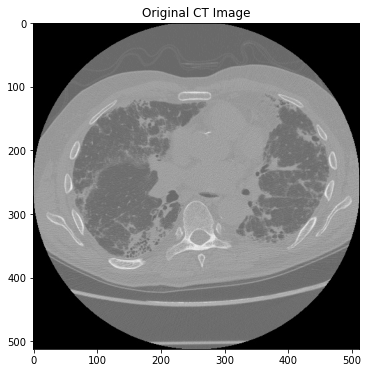

In [9]:
# Select a sample slice to work with
plt.figure(figsize = (12, 6))
im = readImg('sample-dataset/ID00007637202177411956430_16.jpg')
plt.title('Original CT Image')
plt.imshow(im, cmap='gray')
print('Image Dimensions:', im.shape)

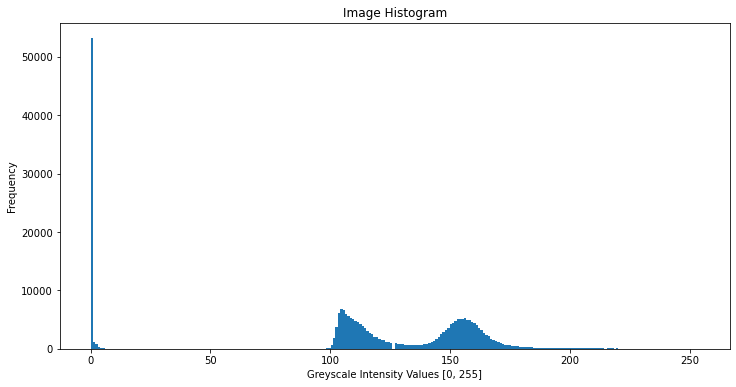

In [10]:
plt.figure(figsize = (12, 6))

plt.title('Image Histogram')
plt.xlabel('Greyscale Intensity Values [0, 255]')
plt.ylabel('Frequency')
plt.hist(im.ravel(), bins=256)
plt.show()

In [49]:
def plotSegmentedImg(img, segmented, K):
    
    # Plot the segmented image
    plt.figure(figsize = (12, 6))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    ax1.imshow(img, cmap='gray')
    ax1.set_title('Original Image')
    
    ax2.imshow(segmented)
    ax2.set_title('CT Image on Segmentation with KMeans of K = ' + str(K))

def plotHistogram(kmmodel, centers, K):
    plt.figure(figsize = (20, 10))

    colors = ['red', 'blue', 'green', 'yellow', 'purple']; i = 0

    # Center lines on the histogram
    for center in centers.values():
        plt.axvline(x = center, c = colors[i])
        plt.text(x = center + 5, 
                 y = 30000, 
                 s = "Center: " + str(center), 
                 c = colors[i])
        i+=1

    plt.title('Image Histogram with Calculated Statistical Parameters')
    plt.xlabel('Greyscale Intensity Values [0, 255]')
    plt.ylabel('Frequency')


    N, bins, patches = plt.hist(im.ravel(), bins=256)

    for i in range(0, len(bins) - 1):
        label = kmmodel.predict([[i]])
        patches[i].set_facecolor(colors[label[0]])

    handles = [Rectangle((0, 0), 1, 1, color=c, ec="k") for c in colors]
    labels = ["Red", "Blue", "Green", "Yellow", "Purple"]
    plt.legend(handles, labels)

    plt.show()

In [50]:
def applyKMeans(img, K, plot_segmented=0, plot_histogram=0):
    
    imflat = np.reshape(im, im.shape[0] * im.shape[1]).reshape(-1, 1)
        
    kmeans = KMeans(K)
    
    kmmodel = kmeans.fit(imflat)
    
    labels = kmmodel.labels_
    centers = kmmodel.cluster_centers_
    
    print(len(labels), 'Labels: \n', labels)
    
    # Center values correspond to intensity values 
    print(len(centers), 'Centers: \n', centers)
    
    # Print centers of labels
    centers_map = dict(zip(np.arange(K), centers))
    print('Labels with corresponding centers:', centers_map)
    
    segmented = np.array([centers_map[label] for label in labels]).reshape(img.shape[0], img.shape[1]) 

    segmented = segmented.astype(int)
    
    if plot_segmented:
        plotSegmentedImg(img, segmented, K)
    
    if plot_histogram:
        plotHistogram(kmmodel, centers_map, K)
    
    return segmented, labels, centers_map

262144 Labels: 
 [1 1 1 ... 1 1 1]
3 Centers: 
 [[1.12269714e+02]
 [8.82521695e-02]
 [1.57879115e+02]]
Labels with corresponding centers: {0: array([112.26971435]), 1: array([0.08825217]), 2: array([157.87911491])}


<Figure size 864x432 with 0 Axes>

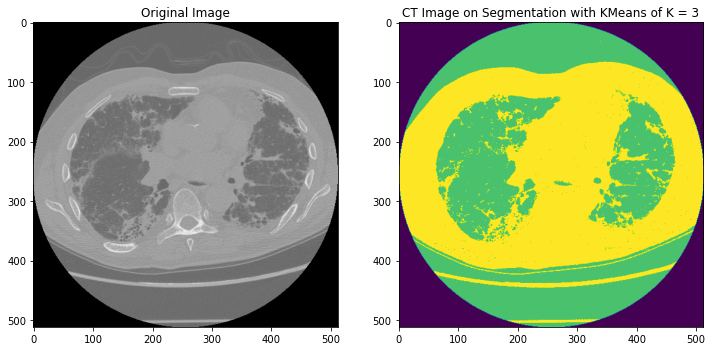

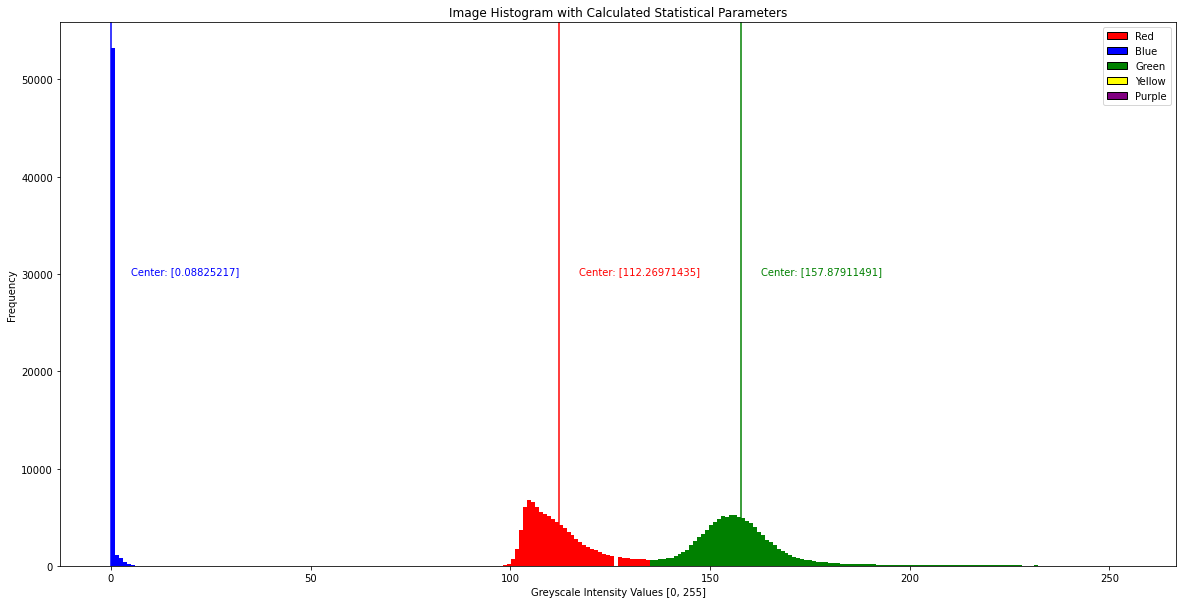

In [51]:
segmented, labels, centers = applyKMeans(im, 3, 1, 1)